# Experiment 1: Acquiring time-domain IQ data following the flux curve and varying the clearing tone frequency and power

**Goal:**

Get `release_rates(clearing_tone_freq, clearing_tone_power)`

**Method:**

- Vary phi, find f(phi), set drive tone to f(phi)
- Vary clearing tone and clearing power and record I,Q data
- Run HMM analysis on the recorded data to get the rates




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from flux_fit import *
from utils import *

ModuleNotFoundError: No module named 'fitTools'

In [4]:
!python -m srsinst.dc205

## Setting up the Experiment


### Variables and Constants

In [5]:
project_name = "Andreev_Spectroscopy"
device_name = "L1A"
run_id = 1
T_MXC = 26
T_Rad = 1.8
experiment_name = f"{device_name}_RUN{run_id}"

drive_path = r"E:\Quasiparticles"
data_path = set_project(r"{}\{}".format(drive_path, project_name), f"{experiment_name}")

# Constants
SPATH = data_path
FIG_PATH = os.path.join(SPATH, "Figures")
LOG_FILE = os.path.join(SPATH, f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log')
PATH_TO_EXE = r'C:/Users/LFL/lflPython/AlazarDrivers/CS_Average/x64/Release/ATS9371_CS_Average.exe'

# Ensure directories exist
os.makedirs(FIG_PATH, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, filemode='w', level=logging.INFO)

Project path set to: E:\Quasiparticles\Andreev_Spectroscopy\032725\L1A_RUN1


The resonances from the flux fit curve - "G:\Shared drives\Labber\Data\2025\03\Data_03016\NBRL1A_flux_sweep_25mK.hdf5" 

In [4]:
resonances = np.array([5.7602,5.7526,5.7406,5.7227,5.7451,5.7558,5.7626,5.7681,5.7718,5.7748,5.7772,5.779,5.7806,5.78042,5.78079,5.78079,5.78035,5.7798,5.7786,5.777,5.77509,5.77231,5.768,5.76335,5.757,5.7482,5.7347,5.7126,5.7493,5.7579])

The sweep voltages for this run was from 28 mV to -30 mV in steps of 2. We want to fit the single flux quanta.

In [5]:
V_start = 28
V_end = -30
steps = -2
remove_first=3
remove_last=2

Original data points: 30
Filtered data points: 25
Removed points at voltages: [ 28  26  24 -28 -30]


/Users/shanto/LFL/QPs/QP_NBR_Experiments/flux_fit.py:185: RuntimeWarning: invalid value encountered in power
  frequency = w0 * (1 + q0 * numerator / safe_denominator) ** exponent



Best fitting parameters:
w0 = 5.781696 GHz
q0 = 0.020198
V_period = -53.166667
V_offset = -1.000000
Sum of squared error = 1.119598e-04


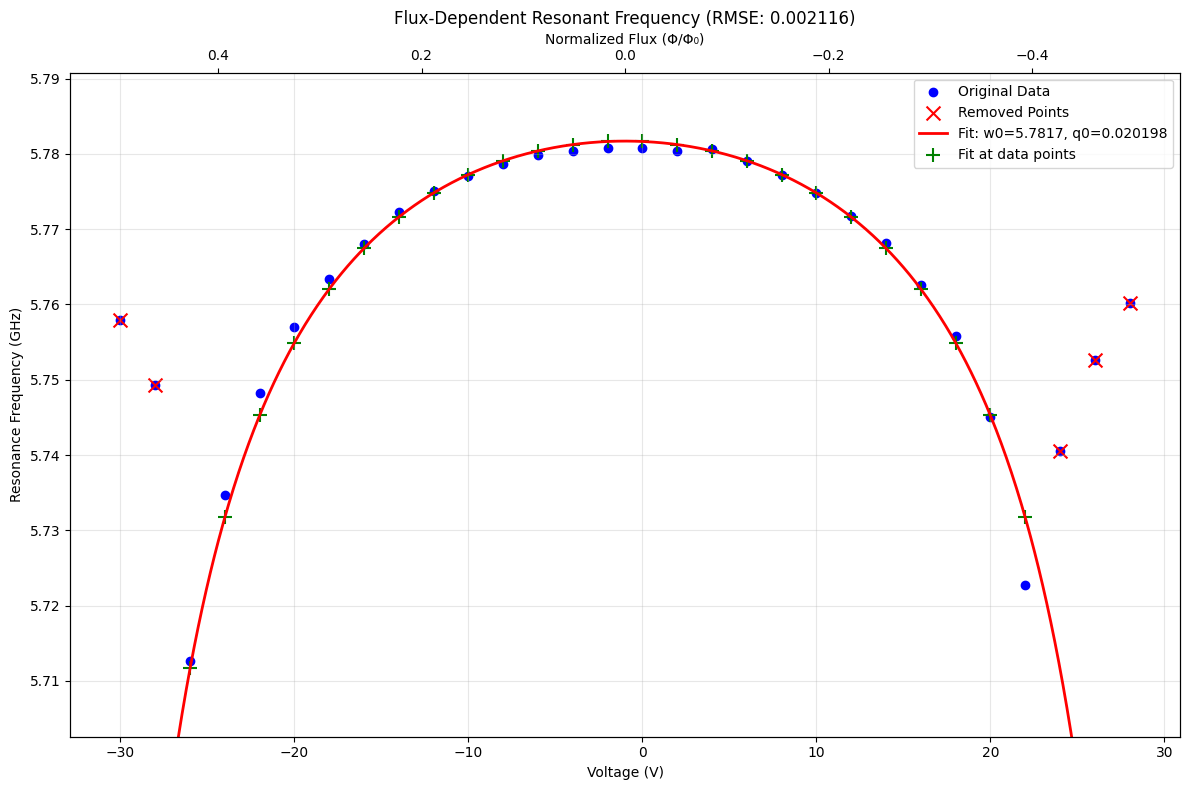

{'w0': 5.781696425756177,
 'q0': 0.02019771764678007,
 'V_period': -53.166666666666664,
 'V_offset': -0.9999999999999964,
 'error': 0.00011195976902623324}

In [7]:
voltages = get_voltage_array(V_start, V_end, steps)
best_fit = fit_resonance_data(resonances, V_start, V_end, steps, remove_first, remove_last)
best_fit

We want to keep track of the other flux quanta branches for accurate frequency mapping.

In [9]:
ofq = other_flux_quanta_resonances(resonances, voltages, remove_first, remove_last, best_fit)
ofq

{'negative_branch': {'flux': array([-0.54545455, -0.50783699, -0.47021944]),
  'voltage': array([28, 26, 24]),
  'resonances': array([5.7602, 5.7526, 5.7406])},
 'positive_branch': {'flux': array([0.50783699, 0.54545455]),
  'voltage': array([-28, -30]),
  'resonances': array([5.7493, 5.7579])}}

some test

In [7]:
print(voltage_to_flux_quanta(-24,best_fit))
print(flux_quanta_to_frequency(0.47, best_fit))
print(find_mapped_resonance(0.47, best_fit))
print(phi_to_voltage(0.47, best_fit, unit='mV'))

0.43260188087774304
5.711812537542725
5.711812537542725
-25.988333333333326


Setting up the phi's and getting the required voltage array with the detuning for the drive tone.

From Eli

"Start ~500 MHz above the resonator and go up to 18 GHz (bandwidth limit of SMA cables). Power, start ~ 5 dB below where you get resonance suppression, maybe go down to 20 dB lower"

In [28]:
phi_low, phi_high = -0.5, -0.3
num_points = 10
phi_arr = np.linspace(phi_low, phi_high, num_points)
# reverse the phi_arr if negative phis
#phi_arr = phi_arr[::-1]
phi_arr

array([-0.5       , -0.47777778, -0.45555556, -0.43333333, -0.41111111,
       -0.38888889, -0.36666667, -0.34444444, -0.32222222, -0.3       ])

In [29]:
v_arr, f_arr = from_flux_fit(phi_arr, best_fit, ofq) # mV, GHz

flux_quanta[0] = -0.500 < -0.46. Using measured data value instead of fitted data.
flux_quanta[1] = -0.478 < -0.46. Using measured data value instead of fitted data.


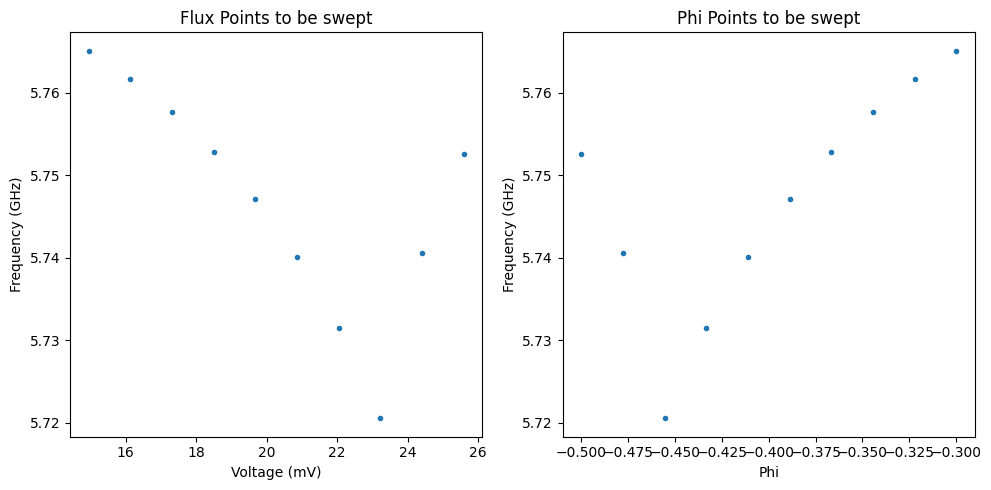

In [30]:
plot_sweep_points(v_arr, f_arr, phi_arr)

### Instrument Setup

In [10]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

Successfully connected to Agilent Network Analyzer E5071B
Successfully connected to Keithley 2400 SourceMeter
Successfully connected to Rohde&Schwarz RF Source
Successfully connected to SignalCore SC5511A Signal Generator_10002F25
Successfully connected to SignalCore SC5511A Signal Generator_1000334C
Successfully connected to Vaunix Lab Brick Digital Attenuator


The labber instrument server config is saved as a hdf5 file in this repository. Instantiating the instruments we need now.

In [11]:
vs = connect_SRS()
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25']
Drive= instruments['SignalCore SC5511A Signal Generator_1000334C']
TWPA_PUMP = instruments['Rohde&Schwarz RF Source']

initialize_instruments(VNA, DA, SMU, LO, Drive, vs, TWPA_PUMP)

In [12]:
vs.check_id()

('DC205', 's/n20500691', 'ver1.80')

In [13]:
# VNA + LO Drive
span = 10e6 # Hz
electrical_delay = 82.584e-9 # s
vna_power = 5
vna_avg = 20
f_d_power = 16

# Clearing
f_low, f_high = 5, 17
f_step = 3
f_clearing_arr = np.arange(f_low, f_high+f_step, f_step)
print(f"f_clearing_arr: {f_clearing_arr}")

P_low, P_high = -10, 17
P_step = 3
P_clearing_arr = np.arange(P_low, P_high+P_step, P_step)
print(f"P_clearing_arr: {P_clearing_arr}")

f_clearing_arr: [ 5  8 11 14 17]
P_clearing_arr: [-10  -7  -4  -1   2   5   8  11  14  17]


From previous runs, I have seen that one sweep point data generates about 1.7 GB of data and takes about a 1.5 minutes (for VNA average set to 20).

In [14]:
print(f"Predicted total data size: {len(phi_arr)*len(f_clearing_arr)*len(P_clearing_arr)*1.5} GB")
print(f"Predicted total time: {len(phi_arr)*len(f_clearing_arr)*len(P_clearing_arr)*1.5/60} hours")

Predicted total data size: 750.0 GB
Predicted total time: 12.5 hours


In [15]:
num_traces=1
acquisitionLength_sec=5
origRateMHz=300
sampleRateMHz=10
averageTimeCycle=0
lowerBound=14 # dB for DA attenuator
upperBound=30# dB for DA attenuator

## The driver code

In [16]:
# Create a log file for the VNA data
lfVNA = Labber.createLogFile_ForData(f'{device_name}_{project_name}_run-{run_id}_flux_sweep',
                                      [{'name':'VNA - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Phi','values':phi_arr,'unit':'flux quanta'}])
initialize_logging(lfVNA, SPATH, PATH_TO_EXE, FIG_PATH, experiment_name, device_name)

Verify the environment


In [ ]:
verify_environment()

Run pre-experiment checks

In [ ]:
pre_experiment_checks()

We have checked in advance that the TWPA pump with the following configuration gives us +20 dB in the entire frequency range of interest.

In [17]:
set_TWPA_pump(f=6.04, power=27)

We have done some rough analysis and found that the QP induced frequency shift is roughly 0.5 MHz so this is what we are going to set as the detuning.


In [18]:
detuning = 0.5e6 # Hz

## Running the experiment without the data transfer daemon:

In [ ]:
start_time = time.time()

for phi in phi_arr:
    print("="*50)
    voltage = phi_to_voltage(phi, best_fit, unit='V')
    print(f"phi: {phi:.6f}, voltage: {voltage:.6f} V")
    set_flux_bias_srs(voltage, step = 5e-5)
    
    turn_off_LO()
    turn_off_clearing()
    f_phi, f_drive = find_resonance(phi, span, best_fit, vna_power, vna_avg, electrical_delay, detuning, show_plot=False, ofq=ofq)
    set_LO_tone(f_drive, f_d_power)
    print(f"f_phi: {f_phi*1e-9:.6f} GHz, f_drive: {f_drive*1e-9:.6f} GHz") 

    for f_clearing in f_clearing_arr:
        for P_clearing in P_clearing_arr:
            print(f"f_clearing: {f_clearing:.6f} GHz, P_clearing: {P_clearing:.6f} dBm")
            set_clearing_tone(f_clearing, P_clearing)
            logging.info(f'\nStarting Alazar acquisition at phi = {phi:.3f} while driving at {f_drive:.6f} GHz')
            savefile = acquire_IQ_data(phi, f_clearing, P_clearing, num_traces, acquisitionLength_sec, origRateMHz, sampleRateMHz, averageTimeCycle, lowerBound, upperBound)
            write_metadata(savefile, acquisitionLength_sec, origRateMHz, f_drive, voltage, T_MXC, T_Rad, phi, f_clearing, P_clearing)
            sleep(0.5)

    logging.info(f'Finished loop for phi = {phi:.3f} in {time.time() - start_time:.2f} seconds')
    print(f'Finished loop for phi = {phi:.3f} in {time.time() - start_time:.2f} seconds')
    current_idx = np.where(phi_arr == phi)[0][0]  # Get the index of current phi
    remaining_time = (time.time() - start_time) * (len(phi_arr) - current_idx - 1) / (current_idx + 1)
    print(f'\n\nEstimated remaining time: {remaining_time:.2f} seconds')
    logging.info(f'Estimated remaining time: {remaining_time:.2f} seconds')

# Close the log file
print(f'Finished flux sweep for {device_name} in {time.time() - start_time:.2f} seconds')
logging.info(f'Finished flux sweep for {device_name} in {time.time() - start_time:.2f} seconds')



## Running the experiment with the data transfer daemon:

In [ ]:
try:
    # Start the daemon
    daemon_process = start_transfer_daemon()
    
    # Main experiment loop
    start_time = time.time()
    try:
        for phi in phi_arr:
            print("="*50)
            voltage = phi_to_voltage(phi, best_fit, unit='V')
            print(f"phi: {phi:.6f}, voltage: {voltage:.6f} V")
            set_flux_bias_srs(voltage, step = 5e-5)
            
            turn_off_LO()
            turn_off_clearing()
            f_phi, f_drive = find_resonance(phi, span, best_fit, vna_power, vna_avg, 
                                          electrical_delay, detuning, show_plot=False, ofq=ofq)
            set_LO_tone(f_drive, f_d_power)
            print(f"f_phi: {f_phi*1e-9:.6f} GHz, f_drive: {f_drive*1e-9:.6f} GHz") 

            for f_clearing in f_clearing_arr:
                for P_clearing in P_clearing_arr:
                    print(f"f_clearing: {f_clearing:.6f} GHz, P_clearing: {P_clearing:.6f} dBm")
                    set_clearing_tone(f_clearing, P_clearing)
                    logging.info(f'\nStarting Alazar acquisition at phi = {phi:.3f} '
                               f'while driving at {f_drive:.6f} GHz')
                    
                    savefile = acquire_IQ_data(phi, f_clearing, P_clearing, num_traces,
                                             acquisitionLength_sec, origRateMHz, sampleRateMHz,
                                             averageTimeCycle, lowerBound, upperBound)
                    
                    write_metadata(savefile, acquisitionLength_sec, origRateMHz, f_drive,
                                 voltage, T_MXC, T_Rad, phi, f_clearing, P_clearing)
                    
                    # Check storage space periodically
                    check_storage_space(SPATH, required_gb=50)  # Adjust threshold as needed
                    sleep(0.5)

            # Progress logging
            logging.info(f'Finished loop for phi = {phi:.3f} in {time.time() - start_time:.2f} seconds')
            print(f'Finished loop for phi = {phi:.3f} in {time.time() - start_time:.2f} seconds')
            
            current_idx = np.where(phi_arr == phi)[0][0]
            remaining_time = (time.time() - start_time) * (len(phi_arr) - current_idx - 1) / (current_idx + 1)
            print(f'\n\nEstimated remaining time: {remaining_time:.2f} seconds')
            logging.info(f'Estimated remaining time: {remaining_time:.2f} seconds')

    except Exception as exp_error:
        logging.error(f"Error during experiment: {str(exp_error)}")
        raise

    finally:
        # Experiment cleanup
        print(f'Finished flux sweep for {device_name} in {time.time() - start_time:.2f} seconds')
        logging.info(f'Finished flux sweep for {device_name} in {time.time() - start_time:.2f} seconds')

except Exception as setup_error:
    logging.error(f"Setup error: {str(setup_error)}")
    raise

finally:
    # Final cleanup
    try:
        # Stop the daemon
        stop_transfer_daemon(daemon_process)
        
        # Cleanup instruments
        turn_off_TWPA_pump()
        turn_off_LO()
        turn_off_clearing()
        turn_off_vna()
        turn_off_SRS(vs)
        
        logging.info("Cleanup completed successfully")
    except Exception as cleanup_error:
        logging.error(f"Error during cleanup: {str(cleanup_error)}")